In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import math
from collections import Counter

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, metrics, model_selection


# Weather Event Classification - Brea Beals


### Objective: 

For this project, we explore the extreme weather events in our dataset. Extreme weather events are defined as weather events that result in damage or inury. Our objective is to classify extreme weather events by type. For this project we will only examine the top 3 weather events: 

* Thunderstorm Wind
* Hail
* Flood

### Methodology: 
This notebook follows the following structure: 

__Part I: Data Preparation__

As mentioned above, the three severe weather events considered in this classification task are Thunderstorm Wind, Hail, and Flood. Prior data prepartation was done in the notebook '01_data_preparation.ipynb', and prior feature engineering and selection were done in the notebook '03_feature_engineering.ipynb', which can be located in the github repository along with this notebook.

__Part II: Modeling__

For each model performance was determined by examining the confusion matrix and classfication report on both the test data and the training data. Overall accuracy, generalization gap, macro average test accuracy, and weighted average test accuracy were specifically examined to determie the model that performed best at overall classfication.

    a) Base Model: Random Forest Classifier
    b) Tuned Random Forest Classifier
    c) Logistic Regression Classifier (using one-vs-rest)
    d) AdaBoost Classifier
    e) KNeighbors Classifier
    f) XGBoost Classifier
    
__Part III: Applying PCA__

PCA is applied to one of the top performing models. The number of components was selected in order to maintian cumulative explained variance of over 90%. 

__Part IV: Applying Sampling Techniques__

These techniques are applied to the best performing model. Random Undersampling was used as the Undersampling technique and SMOTE was used as the Oversampling technique.

    a) Undersampling
    b) Oversampling

__Part V: Summary__

    a) Model Overview
    b) Future Considerations


# Part I: Data Preparation

In [134]:
# loading data
df = pd.read_csv("dat_fe.csv", index_col = "Unnamed: 0")

/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [135]:
df.head()

,latitude,longitude,EVENT_TYPE,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,fraction_cloud_cover,...,fraction_cloud_cover_10_day_min,relative_humidity_10_day_min,temperature_10_day_min,u_component_wind_10_day_min,v_component_wind_10_day_min,vertical_velocity_10_day_min,geo_cluster,year,month,day
0,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,2015,1,4
1,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.532600,265.40286,-1.206722,-13.830118,0.329384,0,2015,1,5
2,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.532600,264.13422,-1.702287,-13.830118,0.310506,0,2015,1,6
3,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.018421,263.48780,-3.931420,-13.830118,-0.045236,0,2015,1,7
4,24.74,-124.779999,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.018421,261.52145,-3.931420,-13.830118,-0.089284,0,2015,1,8


In [136]:
print("Number of extreme weather events: {}".format(df.EVENT_TYPE.value_counts().sum()))

Number of extreme weather events: 61063


In [137]:
print("Number of extreme weather events by category:\n{}".format(df.EVENT_TYPE.value_counts()))

Number of extreme weather events by category:
Thunderstorm Wind           23471
Hail                        14619
Flash Flood                  6885
Flood                        6807
Marine Thunderstorm Wind     4027
Heavy Rain                   2276
Tornado                      2015
Lightning                     963
Name: EVENT_TYPE, dtype: int64


In [138]:
#copying the dataset before altering
df_events = df.copy()

For this project we are making the assumption that "Marine Thunderstorm Wind" and "Thunderstorm Wind" can be combined into one category, as well as "Flash Flood" and "Flood."

In [139]:
#combining thunderstorm wind with marine thunderstorm wind
df_events["EVENT_TYPE"]= df_events["EVENT_TYPE"].str.replace("Marine Thunderstorm Wind", "Thunderstorm Wind")

#combining flash flood with flood
df_events["EVENT_TYPE"]= df_events["EVENT_TYPE"].str.replace("Flash Flood", "Flood") 

In [140]:
df_events.EVENT_TYPE.value_counts()

Thunderstorm Wind    27498
Hail                 14619
Flood                13692
Heavy Rain            2276
Tornado               2015
Lightning              963
Name: EVENT_TYPE, dtype: int64

In [141]:
df_events = df_events[df_events.EVENT_TYPE.isin(["Thunderstorm Wind", "Hail", "Flood"])]
df_events.EVENT_TYPE.value_counts()

Thunderstorm Wind    27498
Hail                 14619
Flood                13692
Name: EVENT_TYPE, dtype: int64

In [142]:
#dropping nas
df_events = df_events.dropna()
#dropping all injury/damage realted columns as well as year and day
df_events = df_events.drop(["INJURIES_DIRECT", "INJURIES_INDIRECT", "DEATHS_DIRECT", "DEATHS_INDIRECT", "DAMAGE_PROPERTY", "DAMAGE_CROPS","year", "day"], axis = 1)

The weather event data is imblananced between the three classes. We will model this multi-class classification with the imbalanced data first, then apply different balancing methods to see if the model can be improved. 

In [143]:
#For modeling with a multi-class classifier

#Multiclass

y = df_events[["EVENT_TYPE"]]
X = df_events.drop(["EVENT_TYPE"], axis = 1)

In [144]:
# Set seed for reproducibility
SEED = 1
# split data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = SEED)

In [145]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

# Part II: Modeling

## A) Multiclass Classification: Random Forest Base Model

In [146]:
# Set seed for reproducibility
SEED = 1

#fitting Random Forest Classifier model
rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train_scaled,y_train)

/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [147]:
#predicted classes for rf baseline model
y_pred_base = rf.predict(X_test_scaled)

Text(0.5, 1, 'Random Forest MultiClass Base Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.76      0.57      0.65      3989
             Hail       0.63      0.58      0.60      4387
Thunderstorm Wind       0.70      0.81      0.75      8360

         accuracy                           0.69     16736
        macro avg       0.70      0.65      0.67     16736
     weighted avg       0.70      0.69      0.69     16736



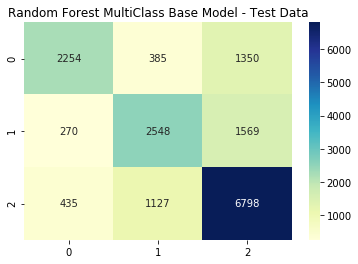

In [148]:
#Test Data: Base Model

#confusion matrix for rf base model
test_matrix_base = confusion_matrix(y_test, y_pred_base)

#plotting heatmap confusion matrix
print(sns.heatmap(test_matrix_base, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Random Forest MultiClass Base Model - Test Data'))


#classification report for rf base model
test_report_base = classification_report(y_test, y_pred_base)
print(test_report_base)

Text(0.5, 1, 'Random Forest MultiClass Base Model - Train Data')
                   precision    recall  f1-score   support

            Flood       1.00      1.00      1.00      9691
             Hail       1.00      1.00      1.00     10232
Thunderstorm Wind       1.00      1.00      1.00     19125

         accuracy                           1.00     39048
        macro avg       1.00      1.00      1.00     39048
     weighted avg       1.00      1.00      1.00     39048



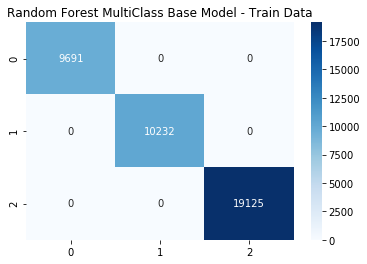

In [55]:
#training data prediction
#predicted classes for rf baseline model 
y_tpred_base = rf.predict(X_train_scaled)

train_matrix_base = confusion_matrix(y_train, y_tpred_base)

#plotting heatmap confusion matrix
print(sns.heatmap(train_matrix_base, annot=True, cmap="Blues",fmt="d").set_title(
'Random Forest MultiClass Base Model - Train Data'))

#classification report for rf base model
train_report_base = classification_report(y_train, y_tpred_base)
print(train_report_base)

Clearly this model is extremely overfit. We will do some hyperparameter tuning to improve the model. 

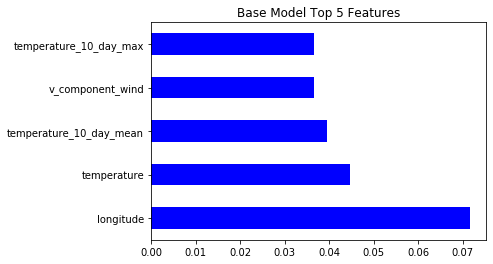

The top 5 feautres for the Random Forest Base Model: 
longitude                  0.071689
temperature                0.044652
temperature_10_day_mean    0.039563
v_component_wind           0.036548
temperature_10_day_max     0.036548
dtype: float64


In [45]:
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_,
index = X_train.columns)
# Sort importances_rf - top 5
sorted_importances_rf = importances_rf.sort_values(ascending = False)[:5]
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='blue')
plt.title("Base Model Top 5 Features")
plt.show()

print("The top 5 feautres for the Random Forest Base Model: \n{}".format(sorted_importances_rf))

## B) Multiclass Classification: Random Searched Random Forest

In [51]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8]
}


#fitting Random Forest Classifier model
rf_gs = RandomForestClassifier(random_state=SEED)

# Create gridsearch object with various combinations of parameters
rf_gs = RandomizedSearchCV(rf, random_grid, cv = 5, 
                       scoring = 'accuracy', 
                       verbose=3,
                       n_jobs = -1)

rf_gs.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [47]:
#best performing model
rf_gs = rf_gs.best_estimator_

In [48]:
#saving model
import pickle
filename = 'rf_gs.sav'
pickle.dump(rf_gs, open(filename, 'wb'))

In [30]:
# load the model from disk
rf_gs = pickle.load(open('rf_gs.sav', 'rb'))

Text(0.5, 1, 'Random Forest MultiClass GridSearch Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.73      0.40      0.51      3989
             Hail       0.57      0.50      0.53      4387
Thunderstorm Wind       0.63      0.81      0.71      8360

         accuracy                           0.63     16736
        macro avg       0.64      0.57      0.59     16736
     weighted avg       0.64      0.63      0.62     16736



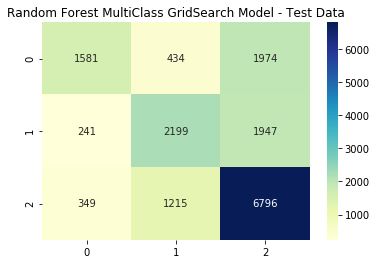

In [31]:
#Test Data: Random Forest Grid Search

#predicted classes for rf grid search model
y_pred_base_gs = rf_gs.predict(X_test_scaled)

#confusion matrix for rf gs model
test_matrix_base_gs = confusion_matrix(y_test, y_pred_base_gs)

#plotting heatmap confusion matrix
print(sns.heatmap(test_matrix_base_gs, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Random Forest MultiClass GridSearch Model - Test Data'))


#classification report for rf gs model
test_report_base_gs = classification_report(y_test, y_pred_base_gs)
print(test_report_base_gs)

Text(0.5, 1, 'Random Forest MultiClass GridSearch Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.80      0.44      0.57      9691
             Hail       0.61      0.53      0.57     10232
Thunderstorm Wind       0.65      0.84      0.73     19125

         accuracy                           0.66     39048
        macro avg       0.69      0.61      0.62     39048
     weighted avg       0.68      0.66      0.65     39048



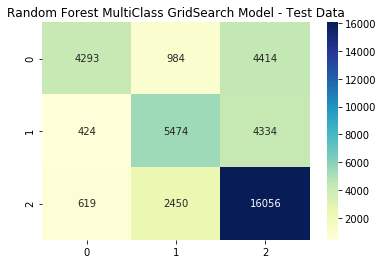

In [32]:
#Training Data: Random Forest Grid Search

#predicted classes for rf grid search model
y_tpred_base_gs = rf_gs.predict(X_train_scaled)

#confusion matrix for rf gs model
train_matrix_base_gs = confusion_matrix(y_train, y_tpred_base_gs)

#plotting heatmap confusion matrix
print(sns.heatmap(train_matrix_base_gs, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Random Forest MultiClass GridSearch Model - Test Data'))


#classification report for rf gs model
train_report_base_gs = classification_report(y_train, y_tpred_base_gs)
print(train_report_base_gs)

We have substantially improved the overfitting from the base model. Our grid searched model has an accuracy of 63% and a weighted accuracy of 62% on the test data. Based on the f1 scores, the harmonic mean between precision and recall, the model is best performing on "Thunderstorm Wind" - which makes sense because it is the class with the most instances. Below we look at which features are most imporatant in our classification: 

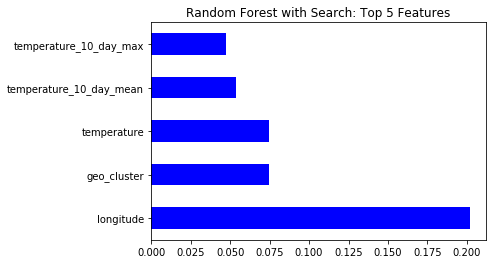

The top 5 feautres for the Random Forest with Search: 
longitude                  0.201994
geo_cluster                0.074837
temperature                0.074837
temperature_10_day_mean    0.053511
temperature_10_day_max     0.047504
dtype: float64


In [33]:
# Create a pd.Series of features importances
importances_rf_gs = pd.Series(rf_gs.feature_importances_,
index = X_train.columns)
# Sort importances_rf - top 5
sorted_importances_rf_gs = importances_rf_gs.sort_values(ascending = False)[:5]
# Make a horizontal bar plot
sorted_importances_rf_gs.plot(kind='barh', color='blue')
plt.title("Random Forest with Search: Top 5 Features")
plt.show()

print("The top 5 feautres for the Random Forest with Search: \n{}".format(sorted_importances_rf_gs))

It is interesitng to note that while longitude still remains the most important feautre, geo_cluster (which was not even in the top 5 before) is now the second most important feature. 

In [57]:
#exploring the distribution of each of the event types within each geo_cluster
df_events.groupby(['geo_cluster', 'EVENT_TYPE']).size()

geo_cluster  EVENT_TYPE       
0            Hail                   940
             Thunderstorm Wind     1361
1            Hail                  2388
             Thunderstorm Wind    12695
2            Hail                  7559
             Thunderstorm Wind     6562
3            Hail                  3732
             Thunderstorm Wind     6867
dtype: int64

It appears that there are a disproportionate amount of Thunderstorm Wind events in geo_cluster 1, and a disproportionate amount of Floods in geo_cluster 0, and a dispropotionate amount of Hail events in geo_cluster 2. geo_cluster 3 follows the same distribution as the data. This indicates that geo_cluster will be extremely imporant in classification. 

Longitude is also an extremely important factor. I explore the longitude distribution below: 

In [54]:
df_events["longitude"].groupby(df_events["EVENT_TYPE"]).describe()

,count,mean,std,min,25%,50%,75%,max
EVENT_TYPE,,,,,,,,
Flood,13680.0,-93.399306,12.532181,-124.779999,-98.739999,-92.019999,-84.459999,-67.659999
Hail,14619.0,-95.965453,9.076016,-124.779999,-102.099999,-97.059999,-90.339999,-67.659999
Thunderstorm Wind,27485.0,-88.872314,10.002352,-124.779999,-95.379999,-86.979999,-81.099999,-67.659999


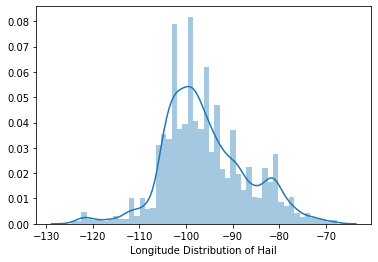

In [62]:
hail_long = df_events.longitude[df_events["EVENT_TYPE"] == "Hail"]
hail_long_dist = pd.Series(hail_long, name="Longitude Distribution of Hail")
sns.distplot(hail_long_dist)

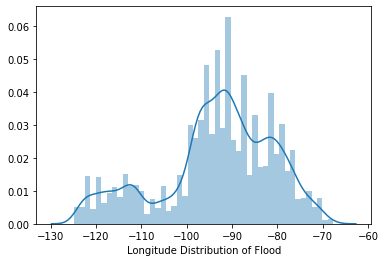

In [63]:
flood_long = df_events.longitude[df_events["EVENT_TYPE"] == "Flood"]
flood_long_dist = pd.Series(flood_long, name="Longitude Distribution of Flood")
sns.distplot(flood_long_dist)

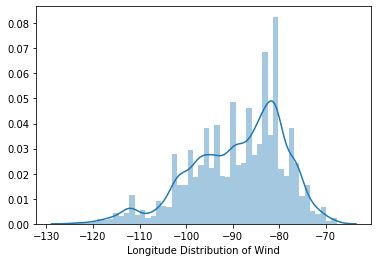

In [64]:
wind_long = df_events.longitude[df_events["EVENT_TYPE"] == "Thunderstorm Wind"]
wind_long_dist = pd.Series(wind_long, name="Longitude Distribution of Wind")
sns.distplot(wind_long_dist)

## C) Multiclass Classification: Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

# Create param grid.
param_grid = { 
    'class_weight': ['dict', 'balanced'],
    'C': [0.001,0.01,0.1,1.,10,100],
    'max_iter': [500]
}


clf = RandomizedSearchCV(lr, param_grid, 
                         scoring ='accuracy', 
                         cv = 5, 
                         verbose=True, 
                         n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.7s finished
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
#best performing model
lr_gs = best_clf.best_estimator_

In [85]:
#saving model
import pickle
filename = 'lr_gs.sav'
pickle.dump(lr_gs, open(filename, 'wb'))

In [86]:
# load the model from disk
lr_gs = pickle.load(open('lr_gs.sav', 'rb'))

Text(0.5, 1, 'Logistic Regression MultiClass GridSearch Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.46      0.49      0.48      3989
             Hail       0.46      0.63      0.53      4387
Thunderstorm Wind       0.71      0.54      0.61      8360

         accuracy                           0.55     16736
        macro avg       0.54      0.56      0.54     16736
     weighted avg       0.58      0.55      0.56     16736



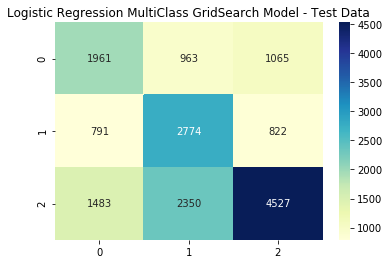

In [87]:
#Test Data: Logistic Regression + RF Grid Search

y_pred_base_lr = lr_gs.predict(X_test_scaled)

test_matrix_base_lr = confusion_matrix(y_test, y_pred_base_lr)

#plotting heatmap confusion matrix
print(sns.heatmap(test_matrix_base_lr, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Logistic Regression MultiClass GridSearch Model - Test Data'))

test_report_base_lr = classification_report(y_test, y_pred_base_lr)
print(test_report_base_lr)

Text(0.5, 1, 'Logistic Regression MultiClass GridSearch Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.48      0.49      0.48      9691
             Hail       0.46      0.65      0.54     10232
Thunderstorm Wind       0.70      0.54      0.61     19125

         accuracy                           0.56     39048
        macro avg       0.55      0.56      0.54     39048
     weighted avg       0.58      0.56      0.56     39048



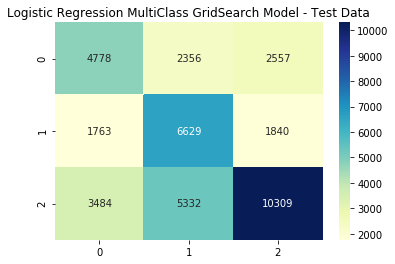

In [88]:
#Training Data: Logistic Regression + RF Grid Search

y_tpred_base_lr = lr_gs.predict(X_train_scaled)

train_matrix_base_lr = confusion_matrix(y_train, y_tpred_base_lr)

#plotting heatmap confusion matrix
print(sns.heatmap(train_matrix_base_lr, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Logistic Regression MultiClass GridSearch Model - Test Data'))

train_report_base_lr = classification_report(y_train, y_tpred_base_lr)
print(train_report_base_lr)

This model has a good balance of bias and variance, but overall underperforms our previous model.

## D) Multiclass Classification: AdaBoost with Grid Search

In [90]:
#fitting AdaBoost Classifier model with default parameters
from sklearn.ensemble import AdaBoostClassifier
ab = AdaBoostClassifier()

In [92]:
#setting grid search parameters
parameters = {'n_estimators':[100, 200, 300, 400], 
              'learning_rate': [0.4,0.6,0.8, 1, 1.2],
              'random_state': [SEED]}

# Create gridsearch object with various combinations of parameters
ab_Grid = RandomizedSearchCV(ab, parameters, cv = 5, 
                       scoring = 'accuracy', 
                       verbose=2,
                       n_jobs = -1)
#fitting model
ab_Grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.1min finished
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': [0.4, 0.6, 0.8, 1,
                                                          1.2],
                                        'n_estimators': [100, 200, 300, 400],
                                        'random_state': [1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=2)

In [93]:
#best performing model
ab_best = ab_Grid.best_estimator_

In [94]:
#saving model
import pickle
filename = 'ab_ml_project.sav'
pickle.dump(ab_best, open(filename, 'wb'))

In [95]:
# load the model from disk
ab_best = pickle.load(open('ab_ml_project.sav', 'rb'))

Text(0.5, 1, 'AdaBoost MultiClass Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.60      0.42      0.49      3989
             Hail       0.55      0.49      0.52      4387
Thunderstorm Wind       0.64      0.77      0.70      8360

         accuracy                           0.61     16736
        macro avg       0.60      0.56      0.57     16736
     weighted avg       0.61      0.61      0.60     16736



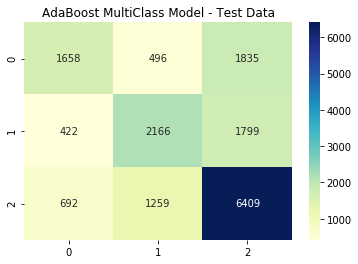

In [96]:
#Test: AdaBoost

#predicted classes for adaboost
y_pred_ab = ab_best.predict(X_test_scaled)


#confusion matrix for adaboost
test_matrix_ab = confusion_matrix(y_test, y_pred_ab)
#plotting heatmap confusion matrix
print(sns.heatmap(test_matrix_ab, annot=True, cmap="YlGnBu",fmt="d").set_title(
'AdaBoost MultiClass Model - Test Data'))


#classification report for adaboost
test_report_ab = classification_report(y_test, y_pred_ab)
print(test_report_ab)

Text(0.5, 1, 'AdaBoost MultiClass Model - Training Data')
                   precision    recall  f1-score   support

            Flood       0.63      0.44      0.52      9691
             Hail       0.58      0.52      0.54     10232
Thunderstorm Wind       0.63      0.77      0.70     19125

         accuracy                           0.62     39048
        macro avg       0.61      0.57      0.59     39048
     weighted avg       0.62      0.62      0.61     39048



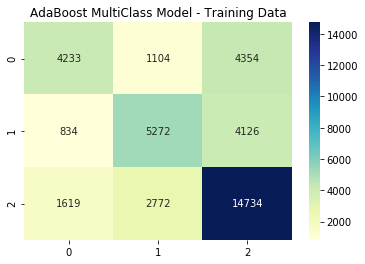

In [97]:
#Training Data: Adaboost

#predicted classes for adaboost
y_pred_ab_train = ab_best.predict(X_train_scaled)

#confusion matrix for adaboost
train_matrix_ab = confusion_matrix(y_train, y_pred_ab_train)
print(sns.heatmap(train_matrix_ab, annot=True, cmap="YlGnBu",fmt="d").set_title(
'AdaBoost MultiClass Model - Training Data'))


#classification report for adaboost
train_report_ab = classification_report(y_train, y_pred_ab_train)
print(train_report_ab)

This model has a small generalzation gap, and is performing relatively well. However, it it still not performing quite as well as our Random Forest Model. 

## E ) KNeighbors Classifier

In [58]:

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6, 7, 10]}]

knn_clf = KNeighborsClassifier()
grid_search = RandomizedSearchCV(knn_clf, 
                                 param_grid, 
                                 cv=5, 
                                 verbose=3, 
                                 n_jobs=-1, 
                                 scoring = "accuracy")

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.9min finished
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions=[{'n_neighbors': [3, 4, 5, 6, 7, 10],
                                         'weights': ['uniform', 'distance']}],
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='accuracy', verbose=3)

In [59]:
#best performing model
knn_best = grid_search.best_estimator_

In [60]:
#saving model
import pickle
filename = 'knn_ml_project.sav'
pickle.dump(knn_best, open(filename, 'wb'))

In [61]:
# load the model from disk
knn_best = pickle.load(open('knn_ml_project.sav', 'rb'))

Text(0.5, 1, 'KNeighbors MultiClass Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.69      0.57      0.63      3989
             Hail       0.59      0.55      0.57      4387
Thunderstorm Wind       0.69      0.77      0.73      8360

         accuracy                           0.66     16736
        macro avg       0.66      0.63      0.64     16736
     weighted avg       0.66      0.66      0.66     16736



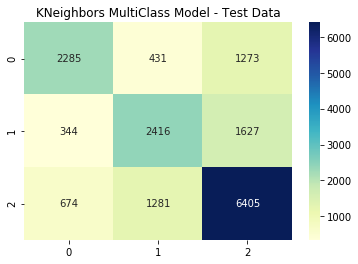

In [62]:

#predicted classes for KNN
y_pred_knn = knn_best.predict(X_test_scaled)


#confusion matrix for KNN
test_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(sns.heatmap(test_matrix_knn, annot=True, cmap="YlGnBu",fmt="d").set_title(
'KNeighbors MultiClass Model - Test Data'))


#classification report for KNN
test_report_knn = classification_report(y_test, y_pred_knn)
print(test_report_knn)

Text(0.5, 1, 'KNeighbors MultiClass Model - Training Data')
                   precision    recall  f1-score   support

            Flood       1.00      1.00      1.00      9691
             Hail       1.00      1.00      1.00     10232
Thunderstorm Wind       1.00      1.00      1.00     19125

         accuracy                           1.00     39048
        macro avg       1.00      1.00      1.00     39048
     weighted avg       1.00      1.00      1.00     39048



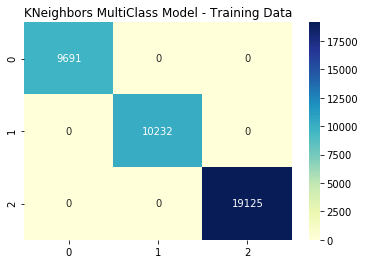

In [63]:
#Training: KNN

#predicted classes for KNN
y_pred_knn_train = knn_best.predict(X_train_scaled)


#confusion matrix for KNN
train_matrix_knn = confusion_matrix(y_train, y_pred_knn_train)
print(sns.heatmap(train_matrix_knn, annot=True, cmap="YlGnBu",fmt="d").set_title(
'KNeighbors MultiClass Model - Training Data'))


#classification report for KNN
train_report_knn = classification_report(y_train, y_pred_knn_train)
print(train_report_knn)

Interestingly, this model is extremely overfit without getting an improvement in accuracy.

## F) XGB Classifier 

In [129]:
from xgboost import XGBClassifier
#fitting RandomizedSearchCV model with default parameters
xgb_clf = XGBClassifier(random_state = SEED)

#creating list for n_estimators, learning_rate, and gamma_list
gamma_list = np.arange(0,2,0.5).tolist()

#setting grid search parameters
parameters_xgb = {'n_estimators': [100, 500, 750], 
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2],
              'max_depth': [1, 2],
              'gamma': gamma_list}

# Create gridsearch object with various combinations of parameters
xgb_rs = RandomizedSearchCV(xgb_clf, parameters_xgb, cv = 5, 
                       scoring = 'accuracy', 
                       verbose=3,
                       n_jobs = -1)
#fitting model
xgb_rs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.1min finished
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=1, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [135]:
#best estimator
xgb_best_est = xgb_rs.best_estimator_

In [136]:
import pickle
# save the model to disk
filename = 'xgb_ml_project.sav'
pickle.dump(xgb_best_est, open(filename, 'wb'))

In [100]:
# load the model from disk
xgb_best_est = pickle.load(open('xgb_ml_project.sav', 'rb'))

Text(0.5, 1, 'XGBoost MultiClass Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.67      0.47      0.55      3989
             Hail       0.57      0.53      0.55      4387
Thunderstorm Wind       0.66      0.77      0.71      8360

         accuracy                           0.64     16736
        macro avg       0.63      0.59      0.60     16736
     weighted avg       0.64      0.64      0.63     16736



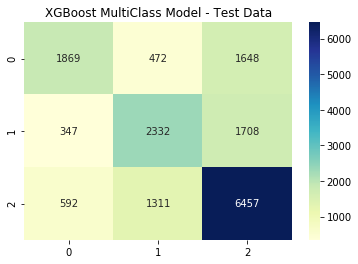

In [142]:
#Test: XGB

y_pred_xgb = xgb_best_est.predict(X_test_scaled)


#confusion matrix for xgb
test_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print(sns.heatmap(test_matrix_xgb, annot=True, cmap="YlGnBu",fmt="d").set_title(
'XGBoost MultiClass Model - Test Data'))


#classification report for xgb
test_report_xgb = classification_report(y_test, y_pred_xgb)
print(test_report_xgb)

Text(0.5, 1, 'XGBoost MultiClass Model - Training Data')
                   precision    recall  f1-score   support

            Flood       0.72      0.50      0.59      9691
             Hail       0.62      0.57      0.60     10232
Thunderstorm Wind       0.67      0.80      0.73     19125

         accuracy                           0.67     39048
        macro avg       0.67      0.63      0.64     39048
     weighted avg       0.67      0.67      0.66     39048



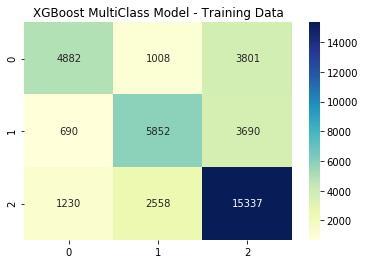

In [140]:
#Train: XGB

y_pred_xgb_train = xgb_best_est.predict(X_train_scaled)

#confusion matrix for xgb
train_matrix_xgb = confusion_matrix(y_train, y_pred_xgb_train)
print(sns.heatmap(train_matrix_xgb, annot=True, cmap="YlGnBu",fmt="d").set_title(
'XGBoost MultiClass Model - Training Data'))


#classification report for xgb
train_report_xgb = classification_report(y_train, y_pred_xgb_train)
print(train_report_xgb)

This is our best model yet. Our overall test accuracy is 1% higher than our second best performing model, but our f1-scores for every class are also higher. This is performing better in recall for Flood and Hail, while also having better precision with Thunderstorm Wind. This is in line with what we want from our model.

Let's look at the feature importances below: 

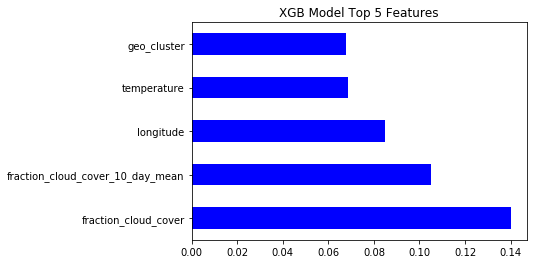

The top 5 feautres for the XGB Model: 
fraction_cloud_cover                0.139981
fraction_cloud_cover_10_day_mean    0.104886
longitude                           0.084950
temperature                         0.068461
geo_cluster                         0.067699
dtype: float32


In [101]:
# Create a pd.Series of features importances
importances_xgb = pd.Series(xgb_best_est.feature_importances_,
index = X_train.columns)
# Sort importances - top 5
sorted_importances_xgb = importances_xgb.sort_values(ascending = False)[:5]
# Make a horizontal bar plot
sorted_importances_xgb.plot(kind='barh', color='blue')
plt.title("XGB Model Top 5 Features")
plt.show()

print("The top 5 feautres for the XGB Model: \n{}".format(sorted_importances_xgb))


This is our first model to not have longitude as the most important feature. The new top two features are fraction_cloud_coverage, and fraction_cloud_coverage_10_day_mean. These two features had not previously appeared in any top 5 feautres list for any of our models. Clearly, this model is learning information from these feautres that the other models had not been able to.

In [108]:
print("Probability Estimates For Each Class: {}".format(xgb_best_est.predict_proba(X_test_scaled[:1])))

Probability Estimates For Each Class: [[0.3239929  0.20896249 0.46704462]]


# Part III: Applying PCA 

Note: applying PCA to our tuned Random Forest Model rather than our XGB Classifier as the XGB Classifer takes well over double the time to run with only 1% better accuracy. If the PCA shows improvement, we will apply it to the XGB Classifer model as well. 

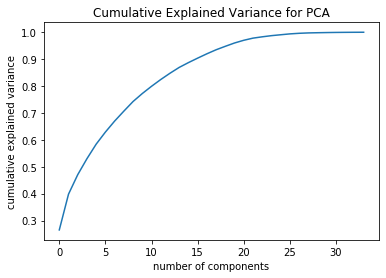

In [84]:
from sklearn.decomposition import PCA

#pca on X_train_scaled
pca = PCA()
pca = pca.fit(X_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Explained Variance for PCA")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [85]:
#cumulative explained variance
np.cumsum(pca.explained_variance_ratio_)[:16]

array([0.2650639 , 0.3980103 , 0.4704846 , 0.53000262, 0.58400197,
       0.62891903, 0.66970303, 0.70671661, 0.74253353, 0.77213915,
       0.79906479, 0.82423239, 0.84755824, 0.86924672, 0.8870888 ,
       0.90373072])

Using only 16 principal components explains over 90% of our variance.

In [92]:
from sklearn.decomposition import PCA

n_comp = 16

#pca on X_train_scaled
pca = PCA(n_components = n_comp, random_state = 1)
X_train_pca = pca.fit_transform(X_train_scaled)

#pca on X_test_scaled
X_test_pca = pca.transform(X_test_scaled)

In [93]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8]
}


#fitting Random Forest Classifier model
rf_pca = RandomForestClassifier(random_state=SEED)

# Create gridsearch object with various combinations of parameters
rf_gs_pca = RandomizedSearchCV(rf_pca, random_grid, cv = 5, 
                       scoring = 'accuracy', 
                       verbose=3,
                       n_jobs = -1)

rf_gs_pca.fit(X_train_pca,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [94]:
#best performing model
rf_gs_pca = rf_gs_pca.best_estimator_

In [95]:
#saving model
import pickle
filename = 'rf_gs_pca.sav'
pickle.dump(rf_gs_pca, open(filename, 'wb'))

In [96]:
# load the model from disk
rf_gs_pca = pickle.load(open('rf_gs_pca.sav', 'rb'))

Text(0.5, 1, 'Random Forest MultiClass GridSearch Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.67      0.31      0.42      3989
             Hail       0.54      0.38      0.44      4387
Thunderstorm Wind       0.60      0.84      0.70      8360

         accuracy                           0.59     16736
        macro avg       0.60      0.51      0.52     16736
     weighted avg       0.60      0.59      0.57     16736



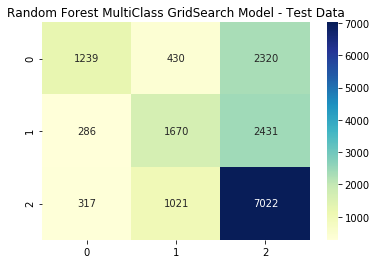

In [97]:
#Test Data: Random Forest Grid Search + PCA

#predicted classes for rf grid search model
y_pred_base_gs_pca = rf_gs_pca.predict(X_test_pca)

#confusion matrix for rf gs model
test_matrix_base_gs_pca = confusion_matrix(y_test, y_pred_base_gs_pca)

#plotting heatmap confusion matrix
print(sns.heatmap(test_matrix_base_gs_pca, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Random Forest MultiClass GridSearch Model - Test Data'))


#classification report for model
test_report_base_gs_pca = classification_report(y_test, y_pred_base_gs_pca)
print(test_report_base_gs_pca)

Text(0.5, 1, 'Random Forest MultiClass GridSearch Model - Test Data')
                   precision    recall  f1-score   support

            Flood       0.79      0.37      0.50      9691
             Hail       0.61      0.44      0.51     10232
Thunderstorm Wind       0.61      0.87      0.72     19125

         accuracy                           0.63     39048
        macro avg       0.67      0.56      0.58     39048
     weighted avg       0.66      0.63      0.61     39048



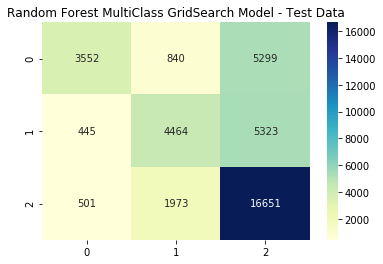

In [98]:
#Training Data: Random Forest Grid Search + PCA

y_tpred_base_gs_pca = rf_gs_pca.predict(X_train_pca)

train_matrix_base_gs_pca = confusion_matrix(y_train, y_tpred_base_gs_pca)

#plotting heatmap confusion matrix
print(sns.heatmap(train_matrix_base_gs_pca, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Random Forest MultiClass GridSearch Model - Test Data'))

train_report_base_gs_pca = classification_report(y_train, y_tpred_base_gs_pca)
print(train_report_base_gs_pca)

PCA did not improve the accuracy of our classifcation by any metric. From inspecting the classification matrix, it's clear that the model is predicting that more of the instances are a "Thunderstorm Wind." This is probably because there are almost double the amount of Thunderstorm Wind events than any other event. The Random Forest fit without PCA is printed below for reference: 

Text(0.5, 1, 'Random Forest MultiClass Base Model - Test Data')


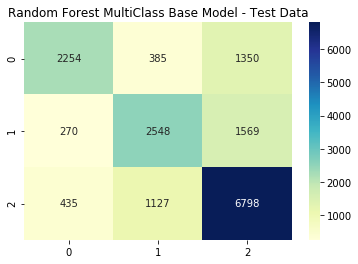

In [125]:
print(sns.heatmap(test_matrix_base, annot=True, cmap="YlGnBu",fmt="d").set_title(
'Random Forest MultiClass Base Model - Test Data'))

# Part IV: Applying Sampling Techniques

We will apply under and over sampling methods to our best performing model, the XGB Classifier, to see if our accuracy is improved.

## A) Undersampling:

In [143]:
#applying undersampling to training data
under = RandomUnderSampler(sampling_strategy='not minority', random_state=SEED)
# fit and apply the transform
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
print(y_train_under.EVENT_TYPE.value_counts())

Flood                9691
Thunderstorm Wind    9691
Hail                 9691
Name: EVENT_TYPE, dtype: int64


In [144]:
#scaling
std_scaler = StandardScaler()
X_train_scaled_under = std_scaler.fit_transform(X_train_under)
X_test_scaled_under = std_scaler.transform(X_test)

In [148]:
#fitting our best model to undersampled data
xgb_rs.fit(X_train_scaled_under,y_train_under)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.2min finished
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=1, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [149]:
#best estimator
xgb_best_under = xgb_rs.best_estimator_

In [150]:
import pickle
# save the model to disk
filename = 'xgb_under_ml_project.sav'
pickle.dump(xgb_best_under, open(filename, 'wb'))

In [151]:
# load the model from disk
xgb_best_under = pickle.load(open('xgb_under_ml_project.sav', 'rb'))

In [152]:
#Test: XGB

y_pred_xgb_under = xgb_best_under.predict(X_test_scaled_under)

#confusion matrix for xgb
test_matrix_xgb_under = confusion_matrix(y_test, y_pred_xgb_under)
print(test_matrix_xgb_under)


#classification report for xgb
test_report_xgb_under = classification_report(y_test, y_pred_xgb_under)
print(test_report_xgb_under)

[[2279  776  934]
 [ 593 2986  808]
 [1394 2202 4764]]
                   precision    recall  f1-score   support

            Flood       0.53      0.57      0.55      3989
             Hail       0.50      0.68      0.58      4387
Thunderstorm Wind       0.73      0.57      0.64      8360

         accuracy                           0.60     16736
        macro avg       0.59      0.61      0.59     16736
     weighted avg       0.62      0.60      0.60     16736



In [153]:
#Train: XGB

y_tpred_xgb_under = xgb_best_under.predict(X_train_scaled_under)

#confusion matrix for xgb
train_matrix_xgb_under = confusion_matrix(y_train_under, y_tpred_xgb_under)
print(train_matrix_xgb_under)


#classification report for xgb
train_report_xgb_under = classification_report(y_train_under, y_tpred_xgb_under)
print(train_report_xgb_under)

[[5721 1711 2259]
 [1205 6762 1724]
 [1596 2447 5648]]
                   precision    recall  f1-score   support

            Flood       0.67      0.59      0.63      9691
             Hail       0.62      0.70      0.66      9691
Thunderstorm Wind       0.59      0.58      0.58      9691

         accuracy                           0.62     29073
        macro avg       0.63      0.62      0.62     29073
     weighted avg       0.63      0.62      0.62     29073



## B) Oversampling with SMOTE

In [104]:
#applying SMOTE to training data
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE('all', random_state = SEED)
X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train)
print(X_train_sm.shape, y_train_sm.shape)
print(y_train_sm.EVENT_TYPE.value_counts())

(57375, 34) (57375, 1)
Flood                19125
Thunderstorm Wind    19125
Hail                 19125
Name: EVENT_TYPE, dtype: int64


In [105]:
#scaling
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train_scaled_sm = std_scaler.fit_transform(X_train_sm)
X_test_scaled_sm = std_scaler.transform(X_test)

In [156]:
#fitting our best model to undersampled data
xgb_rs.fit(X_train_scaled_sm,y_train_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.6min finished
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/breabeals/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=1, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='de

In [163]:
#best estimator
xgb_best_over = xgb_rs.best_estimator_

In [ ]:
import pickle
# save the model to disk
filename = 'xgb_over_ml_project.sav'
pickle.dump(xgb_best_over, open(filename, 'wb'))

In [ ]:
# load the model from disk
xgb_best_over = pickle.load(open('xgb_over_ml_project.sav', 'rb'))

In [106]:
#Test: XGB

y_pred_xgb_over = xgb_best_over.predict(X_test_scaled_sm)

#confusion matrix for xgb
test_matrix_xgb_over = confusion_matrix(y_test, y_pred_xgb_over)
print(test_matrix_xgb_over)


#classification report for xgb
test_report_xgb_over = classification_report(y_test, y_pred_xgb_over)
print(test_report_xgb_over)

[[2152  764 1073]
 [ 637 2895  855]
 [1317 2118 4925]]
                   precision    recall  f1-score   support

            Flood       0.52      0.54      0.53      3989
             Hail       0.50      0.66      0.57      4387
Thunderstorm Wind       0.72      0.59      0.65      8360

         accuracy                           0.60     16736
        macro avg       0.58      0.60      0.58     16736
     weighted avg       0.62      0.60      0.60     16736



In [161]:
#Train: XGB

y_tpred_xgb_over = xgb_best_over.predict(X_train_scaled_sm)

#confusion matrix for xgb
train_matrix_xgb_over = confusion_matrix(y_train_sm, y_tpred_xgb_over)
print(train_matrix_xgb_over)


#classification report for xgb
train_report_xgb_over = classification_report(y_train_sm, y_tpred_xgb_over)
print(train_report_xgb_over)

[[11075  3611  4439]
 [ 2633 13320  3172]
 [ 3115  4641 11369]]
                   precision    recall  f1-score   support

            Flood       0.66      0.58      0.62     19125
             Hail       0.62      0.70      0.65     19125
Thunderstorm Wind       0.60      0.59      0.60     19125

         accuracy                           0.62     57375
        macro avg       0.62      0.62      0.62     57375
     weighted avg       0.62      0.62      0.62     57375



Our undersampling and oversampling techniques did not result in a better model. Both models had a test accuracy 4% lower than our best performing model thus far. 

# Part V: Summary

## A) Model Overview: 

Our three best models arnd their test accuracy/ train accuracy are shown below: 

* __XGBoost Classifier:__

    * Test Accuracy: 0.64
    * Train Accuracy: 0.67
    * Test Weighted Average: 0.63

* __Random Forest Classifier:__

    * Test Accuracy: 0.63
    * Train Accuracy: 0.66
    * Test Weighted Average: 0.62
    
    
* __AdaBoost Classifier:__

    * Test Accuracy: 0.61
    * Train Accuracy: 0.62
    * Test Weighted Average: 0.60


Overall, our best performing model in terms of test accuracy was our XGBoost Classifier, without PCA, and without any form of undersampling or oversampling. The model had a test accuracy of 64% and a train accuracy of 67%. While the model could be improved with a slightly smaller generalization gap, it is expected for the test accuray to be slightly less than the train accuracy, and overall the model is generalizing well. 

Our Random Forest Classifier had only slightly lower test accuracy, 63%, with a training accuracy of 66%. Much like the XGBoost Classifier, there is a 3% difference between the test and train accuracy. Considering the generalization gap is the same, and the XGBoost Classifier outperformed by 1% in both test acccuracy and test weighted average accuracy, we will favor the XGBoost Model over the Random Forest. 

Another model that is worth consideration is the AdaBoost Classifier, with a test accuracy of 61%. While this model slightly performed the other two models mentioned, the AdaBoost Classifier only has a 1% difference between the test and train accuracy. This model appears to be generalizing the best, but at the cost of slightly lower accuracy. 

Interesingly, PCA, and sampling techniques to balance the data did not result in significantly better overall results nor did it help our model see improvement in minority class results. 

Below our the results of how each technique compared to it's base model: 


 * __Applying PCA:__
 
     * Test Accuracy: -4%
     * Train Accuracy: -3%
     * Test Weighted Average: -5%
     
     
 * __Applying Undersampling:__
 
     * Test Accuracy: -4%
     * Train Accuracy: -5%
     * Test Weighted Average: -3%
     
     
 * __Applying Oversampling:__
 
     * Test Accuracy: -4%
     * Train Accuracy: -5%
     * Test Weighted Average: -3%
     

## B)  Future Considerations: 

In the majority of our models, location and temperature related features were the most important. However, in our best performing model, using XGBoost Classifier, features related to fraction cloud coverage were the best. I would be interested in doing a little more digging into fraction cloud coverage to see how I could further engineer that feature. 

I would also like to further engineer the location realted features. Our geoclusters where a great start to grouping the latitude and longitudes into meaningful groups, but I believe more could be done. If I were to continue this project, I would want to match each location to its state using the latitude and longitude. Then, I would map each state to its resepctive region of the country (ie: Midwest, Pacific Northwest, etc) as weather is often regional. 

I would also like to explore more sampling techniques, including a combination of oversampling and undersampling, and broadening the scope of the project to attempt to classify all of the types of severe weather events. 